In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


In [2]:
#Process data
def col_avg(df, gene_col = ['Gene Symbol'], col_name = ''):
    avg_df = df[gene_col].copy()
    if col_name == '':
        #library = get_df_name(df).split('_')[-1] #get library name from df name
        avg_col_name = 'avg'#+library
    else:
        avg_col_name = col_name
    avg_df[avg_col_name] = df.mean(axis = 1)
    return avg_df

## Data Summary

* Schneider et al.
* Cell line: Huh 7.5
* Library: Brunello

In [3]:
#Read counts
reads_raw = pd.read_csv('../../Data/Reads/Poirier/ReadCounts_Poirier.txt', sep = '\t')
#seasonal coronavirus data also included, will drop for now
NL63_cols = [col for col in reads_raw.columns if 'NL63' in col]
OC43_cols = [col for col in reads_raw.columns if 'OC43' in col]
_229E_cols = [col for col in reads_raw.columns if '229E' in col]

cols_to_drop = NL63_cols+OC43_cols+_229E_cols

reads = reads_raw.copy().drop(cols_to_drop, axis = 1)
base_reads = reads[['sgRNA', 'Gene', 'Brunello_Plasmid_DNA_library', 'Brunello_Huh75_Day0']]

#average replicates for temperature conditions 
link_cols = ['sgRNA', 'Gene']
mock_cols = [col for col in reads_raw.columns if 'Mock' in col]
mock_cols = link_cols + mock_cols
mock_reads = reads[mock_cols]

# columns for 33 degrees Celsius condition 
cols_33 = ([col for col in reads.columns if '33' in col])
cols_33 = link_cols + cols_33
reads_33 = reads[cols_33]

# columns for 37 degrees Celsius condition 
cols_37 = ([col for col in reads.columns if '37' in col])
cols_37 = link_cols + cols_37
reads_37 = reads[cols_37]

sars_reads = pd.merge(reads_33, reads_37, on = link_cols, how = 'outer')

reads_clean1 = pd.merge(base_reads, mock_reads, on = link_cols, how = 'outer')
reads_clean = pd.merge(reads_clean1, sars_reads, on = link_cols, how = 'outer')
reads_clean = reads_clean.rename(columns={'sgRNA': 'Guide', 'Gene': 'Gene Symbol', 'Brunello_Plasmid_DNA_library': 'pDNA', 'Brunello_Huh75_Day0':'Day0_control'})
reads_clean

,Guide,Gene Symbol,pDNA,Day0_control,Brunello_Huh75_Mock_A,Brunello_Huh75_Mock_B,Brunello_Huh75_Mock_C,Brunello_Huh75_33C_SARS-CoV_B,Brunello_Huh75_33C_SARS-CoV_C,Brunello_Huh75_33C_SARS-CoV2_A,Brunello_Huh75_37C_SARS-CoV2_A,Brunello_Huh75_37C_SARS-CoV2_B,Brunello_Huh75_37C_SARS-CoV2_C
0,CHDH_GTGCCCACGGACGTAGACCA,CHDH,207,137,288,402,362,244,223,266,237,95,214
1,FBXO11_AACCACTGTAGGGTTAGCAT,FBXO11,115,76,21,17,20,38,48,52,47,31,32
2,NUMBL_ATGGCAGCTCATTCAGCCGT,NUMBL,52,45,84,110,68,60,51,46,12,16,34
3,RXFP4_CTGGGCCCGAATAGCCACCC,RXFP4,89,45,42,92,63,114,79,86,77,38,91
4,NR3C1_ATCAACAGGTCTGATCTCCA,NR3C1,109,99,151,220,136,195,183,119,163,86,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77436,HGC6.3_TCTCCTCCCCACACACTGCA,HGC6.3,0,0,0,0,0,0,0,0,0,0,0
77437,LOC100130357_TCTCCCGCTTCTCCACTCCG,LOC100130357,0,0,0,0,0,0,0,0,0,0,0
77438,C17orf99_TCTCCCAGAAATTACCCCTG,C17orf99,0,0,0,0,0,0,0,0,0,0,0
77439,NTC_CCGTCTCCGCATCGTCTTTT,Non-Targeting_124,0,0,0,0,0,0,0,0,0,0,0


In [4]:
reads_clean[['Guide', 'Gene Symbol', 'pDNA']].to_excel('../../Data/Reads/Poirier/Poirier_Brunello_pDNA.xlsx', index = False)

In [5]:
#Calculate lognorm
cols = reads_clean.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(reads_clean.dropna(), cols = cols)

#Average across replicates
base_lognorms = lognorms.copy()[['Guide', 'Gene Symbol', 'pDNA_lognorm', 'Day0_control_lognorm']]
link_cols = ['Guide', 'Gene Symbol']

#Mock Condition
mock_cols = link_cols + [col for col in lognorms.columns if 'Mock' in col]
mock_lognorms = lognorms[mock_cols]
mock_avg = col_avg(mock_lognorms, gene_col = link_cols, col_name = 'Mock_control_lognorm')

#33 C Condition
cols_33 = link_cols + [col for col in lognorms.columns if '33' in col]
lognorms_33 = lognorms[cols_33]
lognorms_33_avg = col_avg(lognorms_33, gene_col = link_cols, col_name = '33C_SARS_CoV2_lognorm')

#37 C Condition
cols_37 = link_cols + [col for col in lognorms.columns if '37' in col]
lognorms_37 = lognorms[cols_37]
lognorms_37_avg = col_avg(lognorms_37, gene_col = link_cols, col_name = '37C_SARS_CoV2_lognorm')


sars_lognorms = pd.merge(lognorms_33_avg, lognorms_37_avg, on = link_cols, how = 'outer')

lognorms_clean1 = pd.merge(base_lognorms, mock_avg, on = link_cols, how = 'outer')
lognorms_clean = pd.merge(lognorms_clean1, sars_lognorms, on = link_cols, how = 'outer')

lognorms_clean


,Guide,Gene Symbol,pDNA_lognorm,Day0_control_lognorm,Mock_control_lognorm,33C_SARS_CoV2_lognorm,37C_SARS_CoV2_lognorm
0,CHDH_GTGCCCACGGACGTAGACCA,CHDH,5.251061,5.209091,5.865031,5.237510,5.357769
1,FBXO11_AACCACTGTAGGGTTAGCAT,FBXO11,4.433057,4.389955,2.065297,2.978736,3.257866
2,NUMBL_ATGGCAGCTCATTCAGCCGT,NUMBL,3.366734,3.680523,3.919913,3.145071,2.454377
3,RXFP4_CTGGGCCCGAATAGCCACCC,RXFP4,4.082680,3.680523,3.501575,3.892178,4.021196
4,NR3C1_ATCAACAGGTCTGATCTCCA,NR3C1,4.359423,4.755308,4.821331,4.668850,4.874651
...,...,...,...,...,...,...,...
77436,HGC6.3_TCTCCTCCCCACACACTGCA,HGC6.3,0.000000,0.000000,0.000000,0.000000,0.000000
77437,LOC100130357_TCTCCCGCTTCTCCACTCCG,LOC100130357,0.000000,0.000000,0.000000,0.000000,0.000000
77438,C17orf99_TCTCCCAGAAATTACCCCTG,C17orf99,0.000000,0.000000,0.000000,0.000000,0.000000
77439,NTC_CCGTCTCCGCATCGTCTTTT,Non-Targeting_124,0.000000,0.000000,0.000000,0.000000,0.000000


## Quality Control
### Population Distributions

../../Figures/Huh75_Brunello_popdist.png


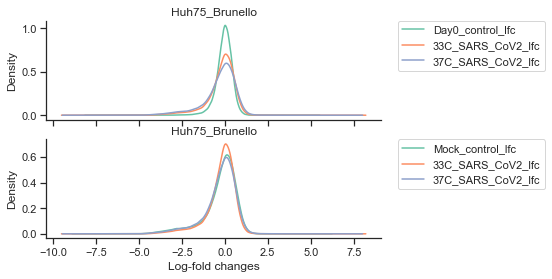

In [6]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms_clean.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms_clean,target_cols)
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id = 'control', res_id = 'SARS', filename = 'Huh75_Brunello')

### Control Distributions

../../Figures/Huh75_Brunello_controldist.png


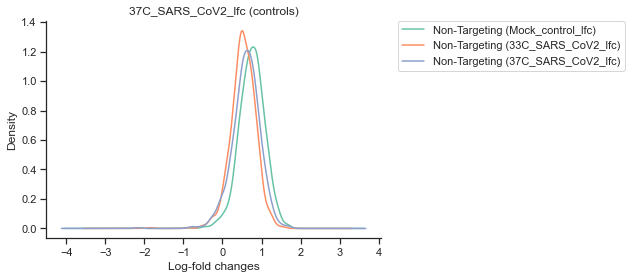

In [7]:
fns.control_dist_plot(pDNA_lfc, initial_id= 'Mock', res_id='SARS', control_name=['Non-Targeting'], filename='Huh75_Brunello')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

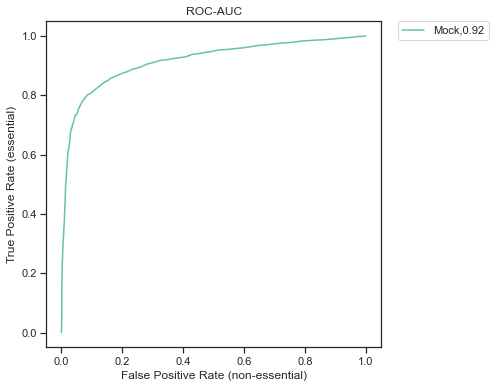

In [8]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col='Mock_control_lfc')

fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Mock,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [9]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

# guide_residuals_day0_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df.drop('Mock_control_lfc', axis = 1))
guide_residuals_mock_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df.drop('Day0_control_lfc', axis = 1), initial_id= 'Mock', res_id='SARS')

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

# gene_residuals_day0 = anchors.get_gene_residuals(guide_residuals_day0_lfcs, guide_mapping)
gene_residuals_mock = anchors.get_gene_residuals(guide_residuals_mock_lfcs, guide_mapping)


            modified       unperturbed
0  33C_SARS_CoV2_lfc  Mock_control_lfc
1  37C_SARS_CoV2_lfc  Mock_control_lfc


In [10]:
# gene_residual_sheet_day0 = format_gene_residuals(gene_residuals_day0)
gene_residual_sheet_mock = fns.format_gene_residuals(gene_residuals_mock, guide_min=3, guide_max=5)
# guide_residual_sheet_day0 = pd.merge(guide_mapping, guide_residuals_day0_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet_mock = pd.merge(guide_mapping, guide_residuals_mock_lfcs, on = 'Guide', how = 'outer')


['33C_SARS_CoV2_lfc', '37C_SARS_CoV2_lfc']
33C_SARS_CoV2_lfc
37C_SARS_CoV2_lfc


In [11]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Huh75_Brunello_Poirier_v2.xlsx') as writer:  
    gene_residual_sheet_mock.to_excel(writer, sheet_name='Huh75_Brunello_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Huh75_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Huh75_Brunello_guide_mapping', index =False)

In [12]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Huh75_Brunello_Poirier_v3.xlsx') as writer:   
    gene_residuals_mock.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet_mock.to_excel(writer, sheet_name='guide-level_zscore', index =False)